In [4]:
from pytorch_vision_classifier.pytorch_dataset_samplers import ImbalancedDatasetSampler
from pytorch_vision_classifier.pytorch_dataset_preparation import PytorchDatasetPreparation
from pytorch_vision_classifier.pytorch_device_manager import DeviceManager
from pytorch_vision_classifier.pytorch_model_training import ModelInitializer, ModelTraining

from classification_analysis.classification_analysis import MetricsVisualization

import pickle as pk
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, MultiStepLR
from torchvision import transforms, models

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

In [5]:
# Device information
dvc_mng = DeviceManager()
dvc_mng.available_gpus_info()
device = dvc_mng.get_gpu_device(0)

Number of GPUs :  1 

* GPU index : 0 	 GPU name : Tesla T4 	 RAM : 15.812 [GB] 



In [6]:
# Load the dataset and dataset description
dataset_dir = ['hymenoptera_data']   # Dataset directory

show_images_dims_summary = False

data_splitting_parameters = {
    'validation_ratio': 0.2,
    'splitting_random_state': 1,
}

data_loading_parameters = {
    'training_batch_size': 16,
    'validation_batch_size': 16,
    
    'training_shuffle': False,
    'validation_shuffle': False,
    
    'training_num_workers': 3,
    'validation_num_workers': 3,
    
    'training_pin_memory': True,
    'validation_pin_memory': True,
    
    'training_sampler_class': None, # Could be None
    'training_sampler_parameters': {'data_source': True, 'indices':None, 'num_samples':24960},
}

if data_loading_parameters['training_sampler_class'] is None:
    sampler = 'Uniform'    
else:
    sampler = data_loading_parameters['training_sampler_class'].__name__

# Data transformation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the dataset
dataset = PytorchDatasetPreparation(dataset_dir = dataset_dir,
                                    splitting_parameters = data_splitting_parameters,
                                    loading_parameters = data_loading_parameters,
                                    data_transforms = data_transforms,
                                    show_images_dims_summary = show_images_dims_summary,
                                    aws = False)

dataset

Done


* Root directory : 
['/content/drive/My Drive/Pytorch/pytorch vision classifier/hymenoptera_data']

* Classes details : 
Number of classes : 2
Available classes : {'ants': 0, 'bees': 1}

* Dataset
** Extensions details : 
Available extensions : ['.jpg']
Number of samples per extension : 
.jpg    397
dtype: int64

** Samples details : 
Number of samples : 397
Number of samples per class and per extension : 
            class_name number_of_samples .jpg
class_index                                  
0                 ants               193  193
1                 bees               204  204
Classes percentages : [0.486 0.514]
Classes weights : [2.058 1.946]


* Training Dataset
** Extensions details : 
Available extensions : ['.jpg']
Number of samples per extension : 
.jpg    317
dtype: int64

** Samples details : 
Number of samples : 317
Number of samples per class and per extension : 
            class_name number_of_samples .jpg
class_index                                  
0           

In [7]:
# Model
model_name = 'resnet18'
model_initializer = ModelInitializer(model_name = model_name, 
                                     use_pretrained = True, 
                                     update_head = {'update': True,
                                                    'init_mode': 'xavier_normal',
                                                    'val': None}, 
                                     num_classes = dataset.number_of_classes,
                                     dropout = {'add_dropout': False, 'prob': None})

# Get a model (All layers are non trainble)
model = model_initializer.get_model()
ModelInitializer.update_trainability([model.fc], trainable = True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [7]:
# Loss function 
loss_function = nn.CrossEntropyLoss()

# Optimizer
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Scheduler
scheduler = MultiStepLR(optimizer, milestones=[5, 40, 80], gamma=0.1)

# Epoch
num_epochs = 50

In [8]:
model_training = ModelTraining(model = model,
                                    model_name = model_name,
                                    device = device,
                                    loss_function = loss_function,
                                    optimizer = optimizer,
                                    scheduler = scheduler,
                                    num_epochs = num_epochs,
                                    input_type={'train': 'single_crop','validation': 'single_crop'},
                                    save_model_rate = 5, 
                                    save_last_model = True)

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


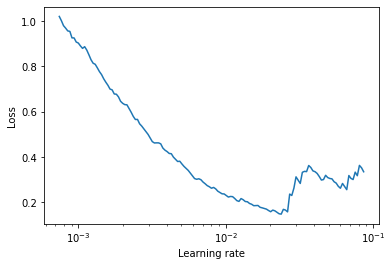

In [9]:
# For more information refer to https://github.com/davidtvs/pytorch-lr-finder
# If you want to find the best learning rate
model_training.find_best_learning_rate(dataset, num_iter=300,
                                       use_val_loss = False, end_lr = 10, step_mode='exp')

Epoch 50/50
Current learning rate: 5e-06 
Confusion Matrix



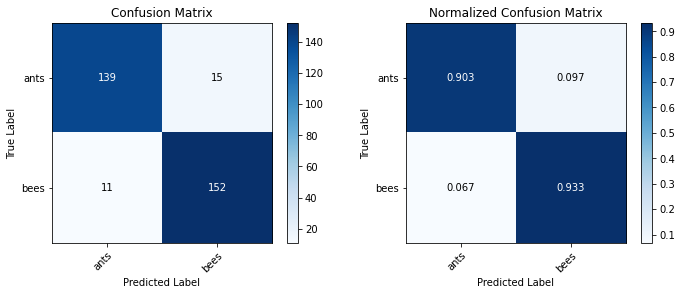


Confusion Tables



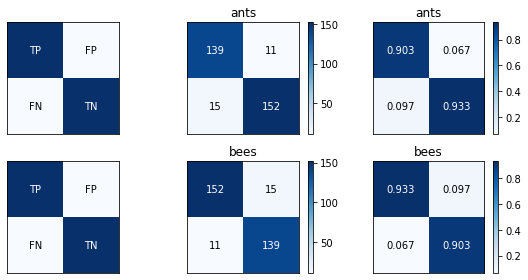


Overall Metrics



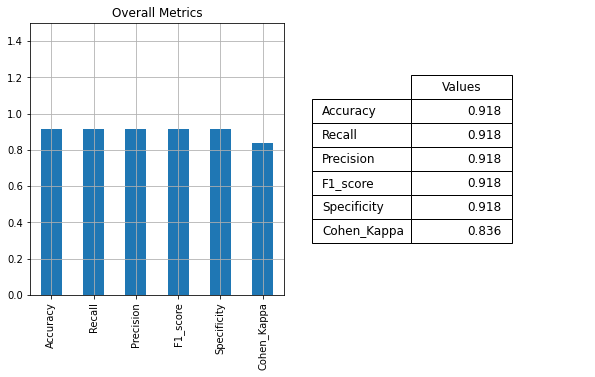


Classes Metrics



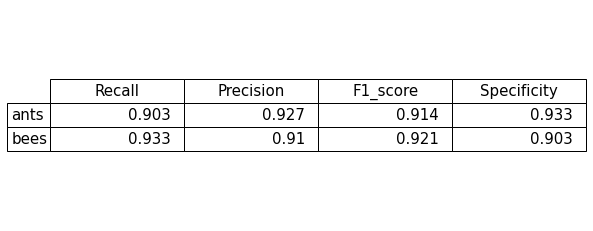

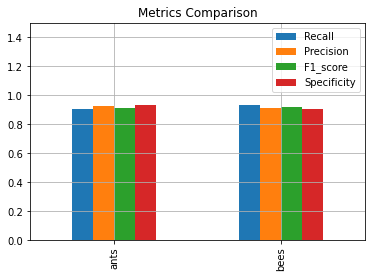

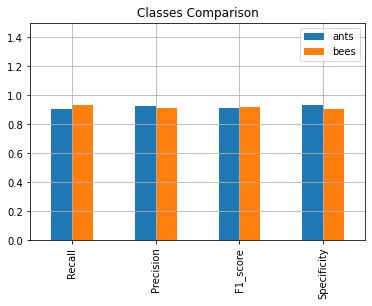


ROC Curve



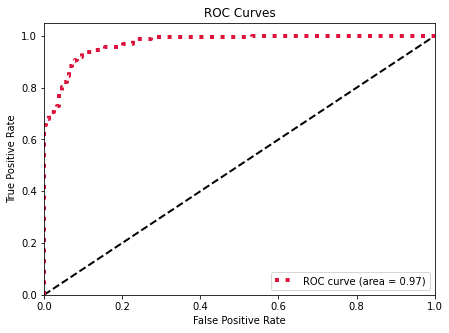

Confusion Matrix



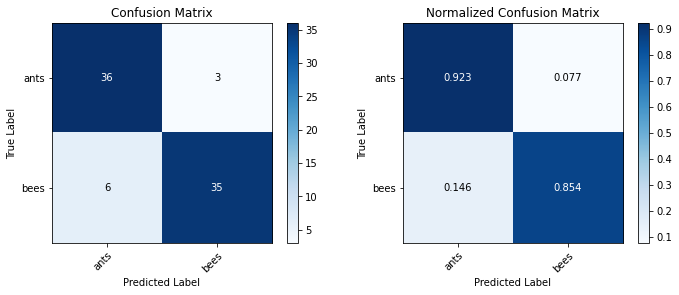


Confusion Tables



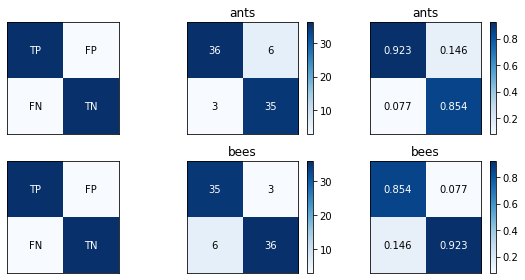


Overall Metrics



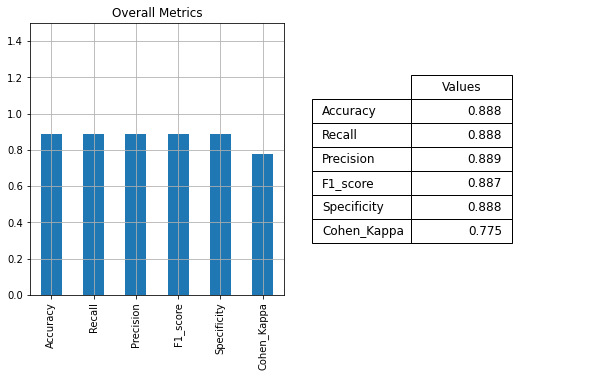


Classes Metrics



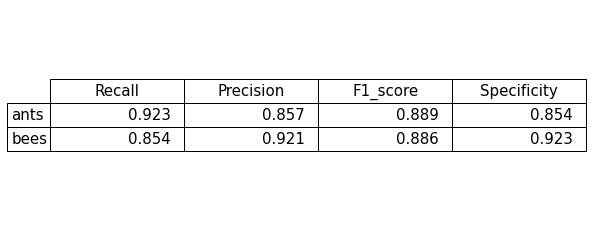

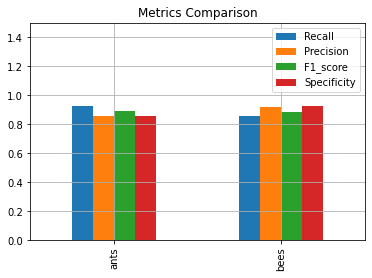

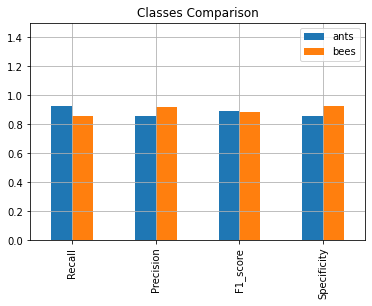


ROC Curve



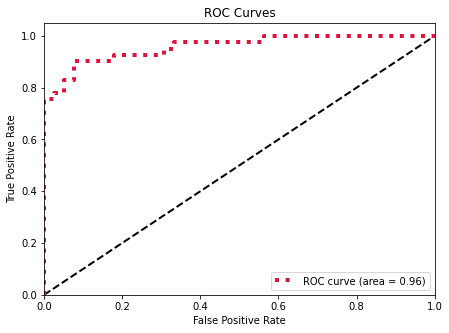



Training loss Min: 0.258, Max: 0.879 in epoch 0, Current: 0.258
Validation loss Min: 0.276, Max: 0.695 in epoch 0, Current: 0.276


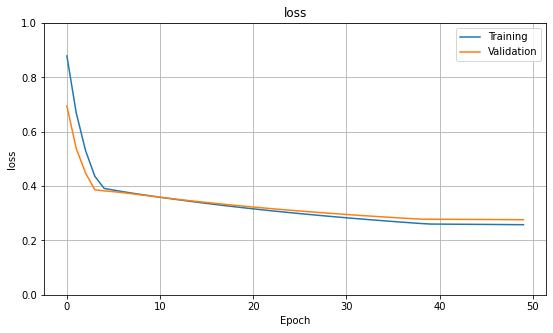



Training overall_accuracy Min: 0.546, Max: 0.918 in epoch 49, Current: 0.918
Validation overall_accuracy Min: 0.638, Max: 0.888 in epoch 37, Current: 0.888


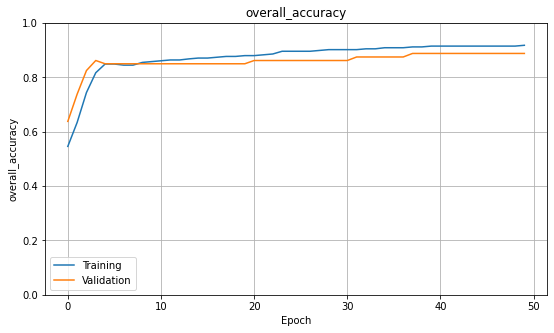



Training overall_cohen_kappa Min: 0.092, Max: 0.836 in epoch 49, Current: 0.836
Validation overall_cohen_kappa Min: 0.273, Max: 0.775 in epoch 37, Current: 0.775


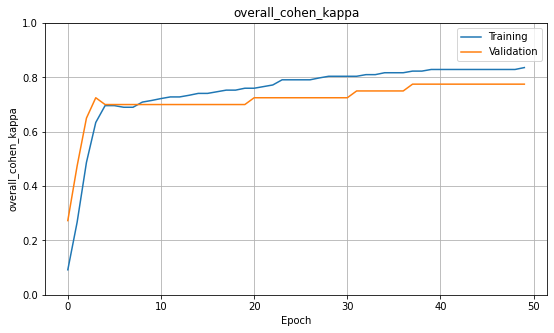



Training overall_recall Min: 0.546, Max: 0.918 in epoch 49, Current: 0.918
Validation overall_recall Min: 0.636, Max: 0.888 in epoch 37, Current: 0.888


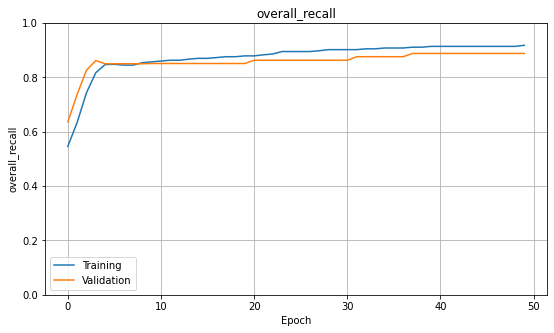



Training overall_f1_score Min: 0.546, Max: 0.918 in epoch 49, Current: 0.918
Validation overall_f1_score Min: 0.636, Max: 0.887 in epoch 37, Current: 0.887


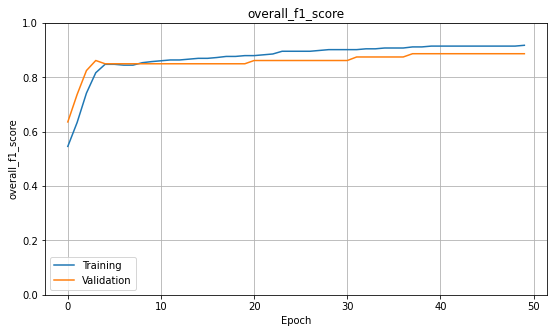



Training overall_precision Min: 0.546, Max: 0.918 in epoch 49, Current: 0.918
Validation overall_precision Min: 0.638, Max: 0.889 in epoch 37, Current: 0.889


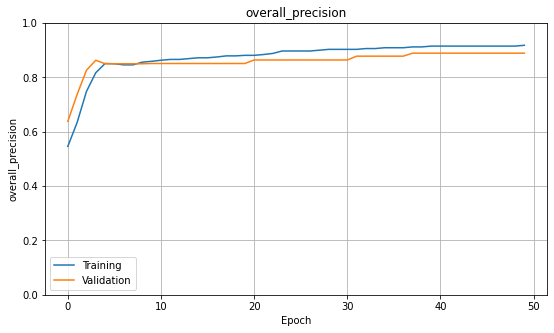



Training overall_specificity Min: 0.546, Max: 0.918 in epoch 49, Current: 0.918
Validation overall_specificity Min: 0.636, Max: 0.888 in epoch 37, Current: 0.888


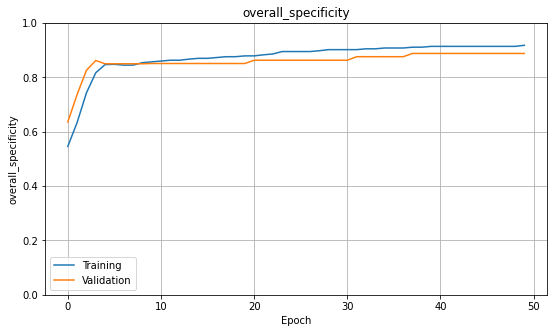

One epoch takes 0 [m] 11 [s]


In [10]:
# Training loop (Consider val_acc as the mertic to be followed)
# This function will show updated training dashboard during the model training
# This function will create a pickle file contains the best model and the evaluation metrics
model_training.loop(dataset, best='val_acc', reset_epoch_cnt=True)

Confusion Matrix



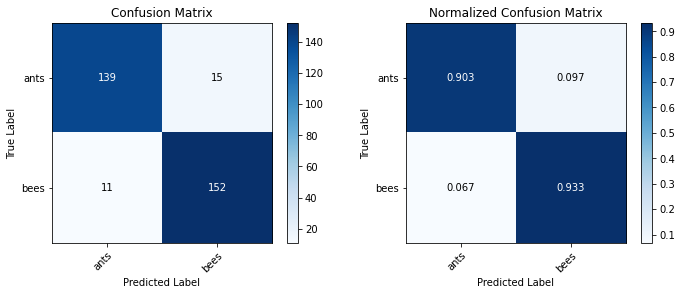


Confusion Tables



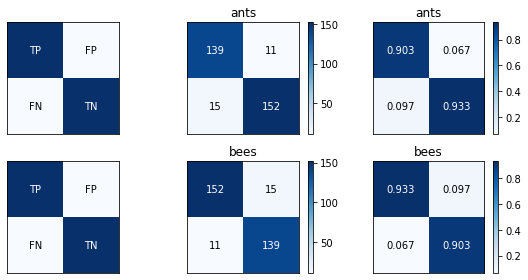


Overall Metrics



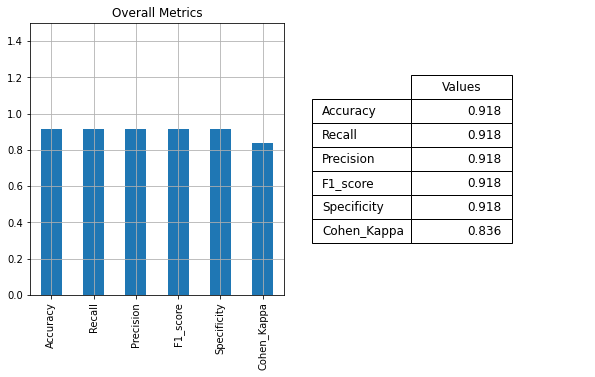


Classes Metrics



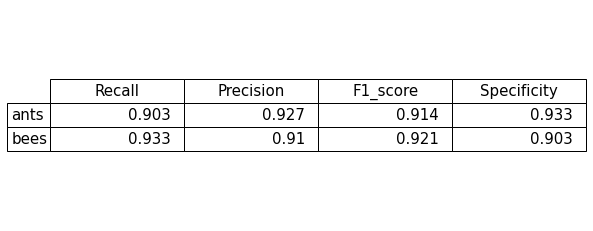

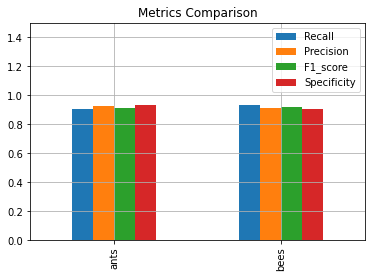

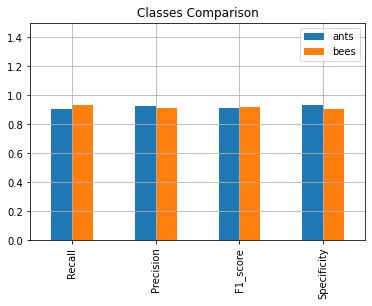


ROC Curve



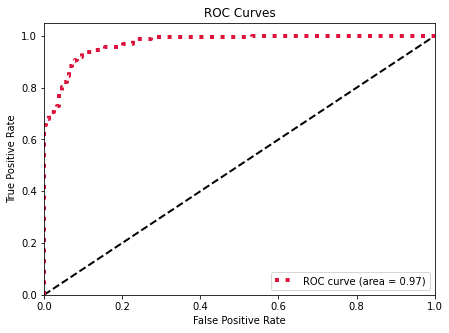

Confusion Matrix



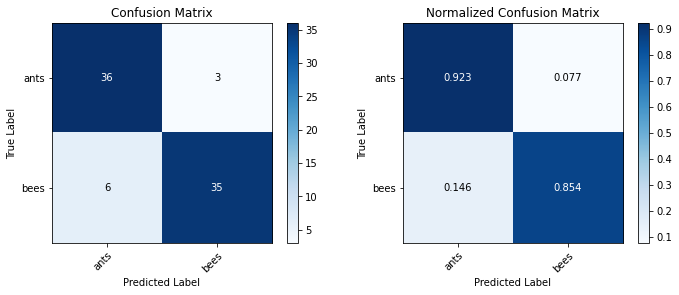


Confusion Tables



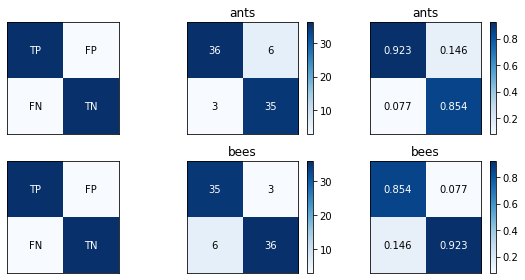


Overall Metrics



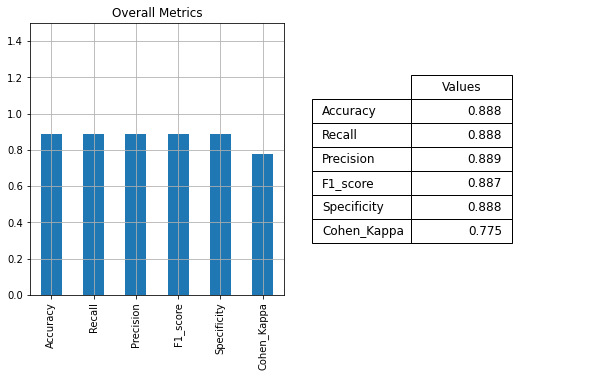


Classes Metrics



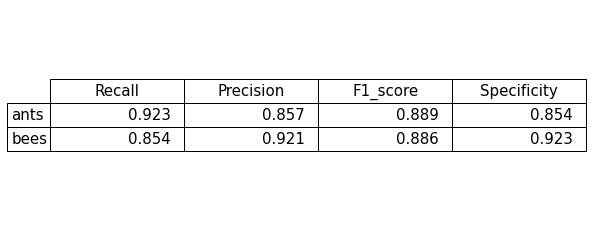

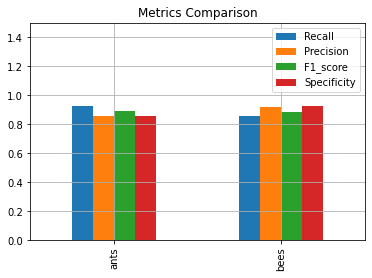

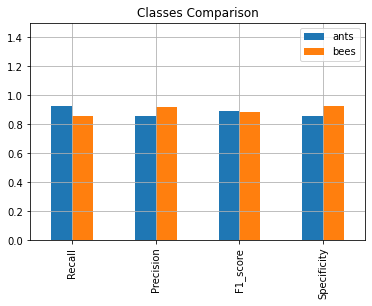


ROC Curve



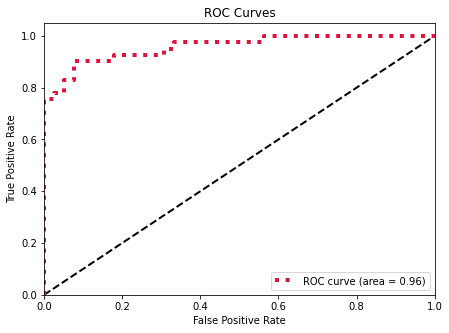



Training loss Min: 0.258, Max: 0.879 in epoch 0, Current: 0.258
Validation loss Min: 0.276, Max: 0.695 in epoch 0, Current: 0.276


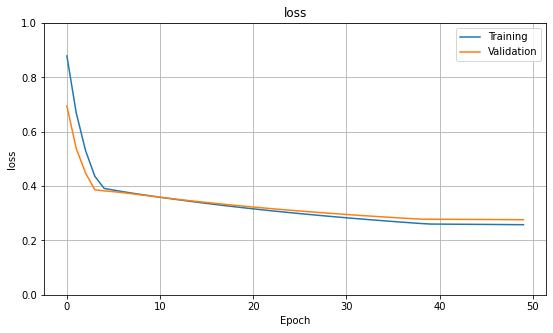



Training overall_accuracy Min: 0.546, Max: 0.918 in epoch 49, Current: 0.918
Validation overall_accuracy Min: 0.638, Max: 0.888 in epoch 37, Current: 0.888


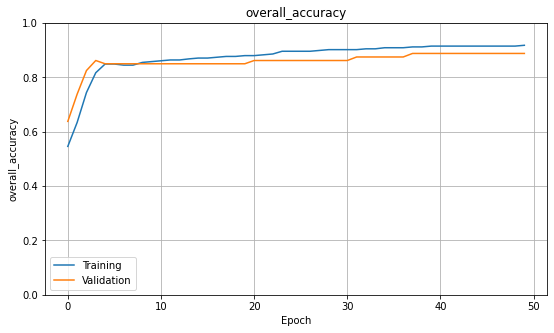



Training overall_cohen_kappa Min: 0.092, Max: 0.836 in epoch 49, Current: 0.836
Validation overall_cohen_kappa Min: 0.273, Max: 0.775 in epoch 37, Current: 0.775


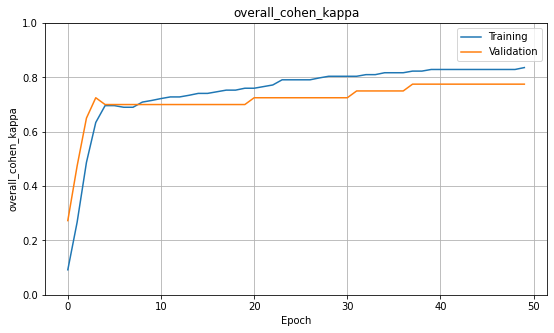



Training overall_recall Min: 0.546, Max: 0.918 in epoch 49, Current: 0.918
Validation overall_recall Min: 0.636, Max: 0.888 in epoch 37, Current: 0.888


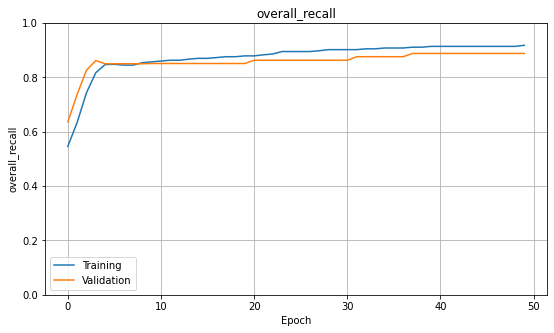



Training overall_f1_score Min: 0.546, Max: 0.918 in epoch 49, Current: 0.918
Validation overall_f1_score Min: 0.636, Max: 0.887 in epoch 37, Current: 0.887


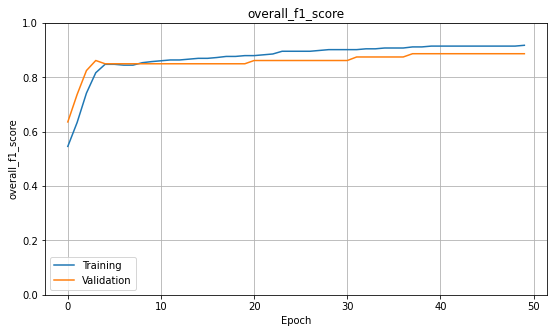



Training overall_precision Min: 0.546, Max: 0.918 in epoch 49, Current: 0.918
Validation overall_precision Min: 0.638, Max: 0.889 in epoch 37, Current: 0.889


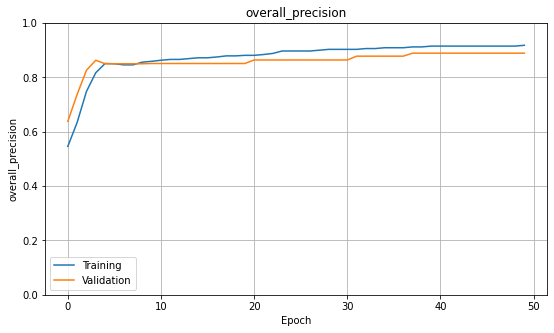



Training overall_specificity Min: 0.546, Max: 0.918 in epoch 49, Current: 0.918
Validation overall_specificity Min: 0.636, Max: 0.888 in epoch 37, Current: 0.888


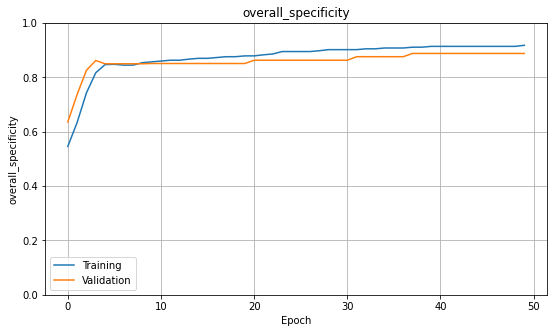

In [11]:
# Restore last model
model_pkl = f'{model_name}.pkl'

# Last Evaluation metrics
ModelTraining.last_model_metrics_visualization(model_pkl)

Confusion Matrix



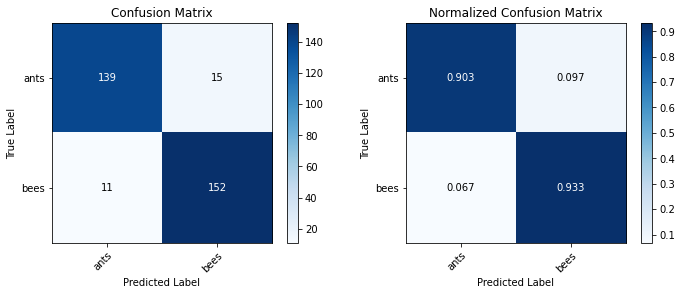


Confusion Tables



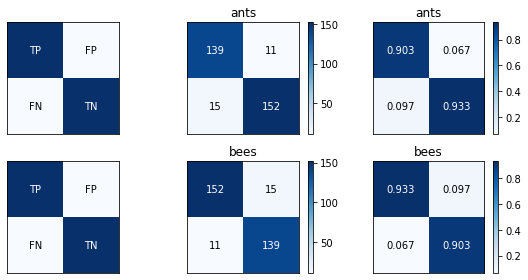


Overall Metrics



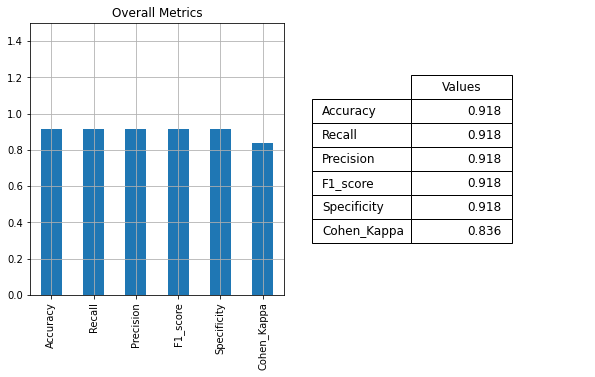


Classes Metrics



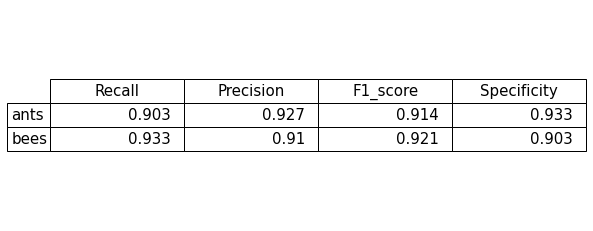

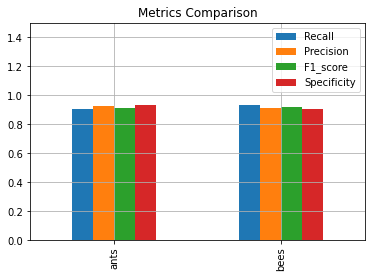

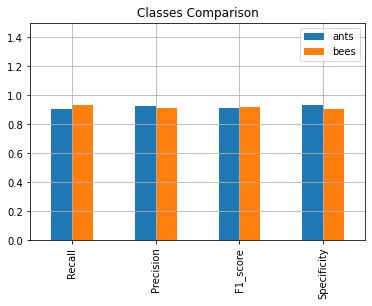


ROC Curve



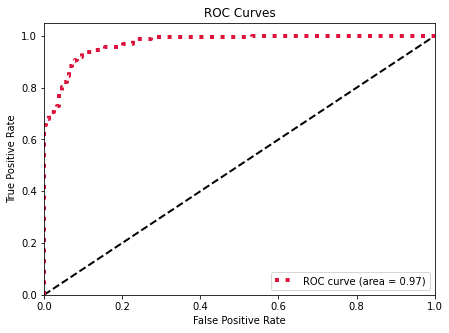

Confusion Matrix



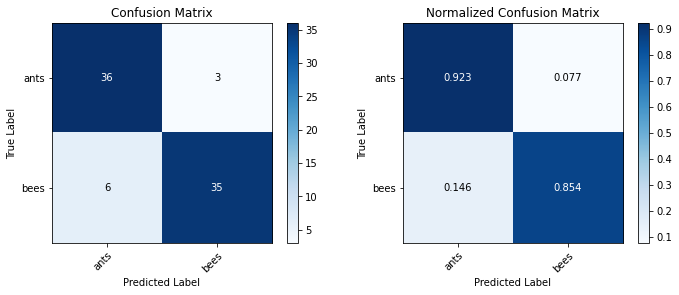


Confusion Tables



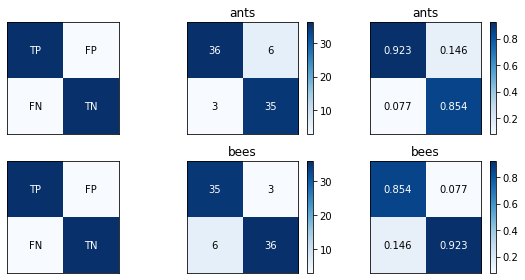


Overall Metrics



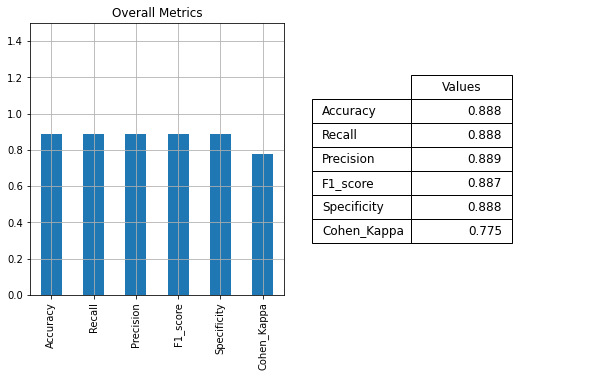


Classes Metrics



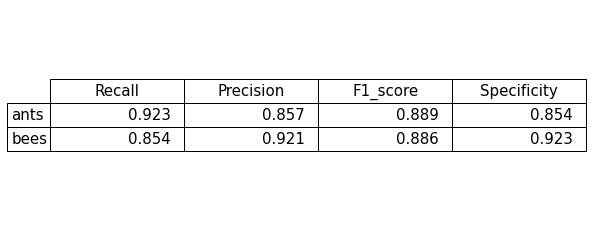

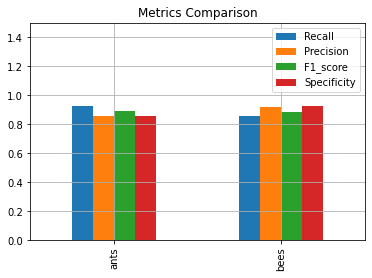

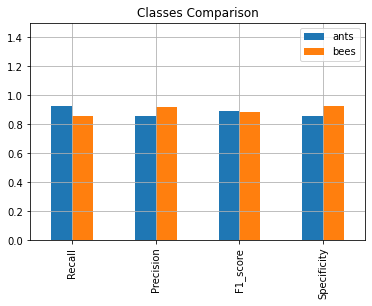


ROC Curve



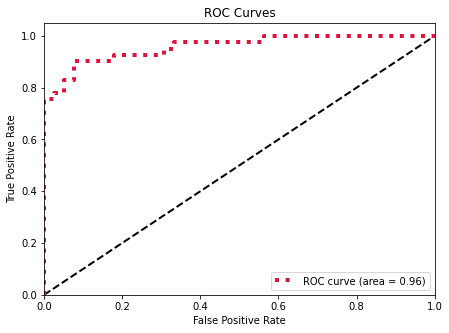



Training loss Min: 0.258, Max: 0.879 in epoch 0, Current: 0.258
Validation loss Min: 0.276, Max: 0.695 in epoch 0, Current: 0.276


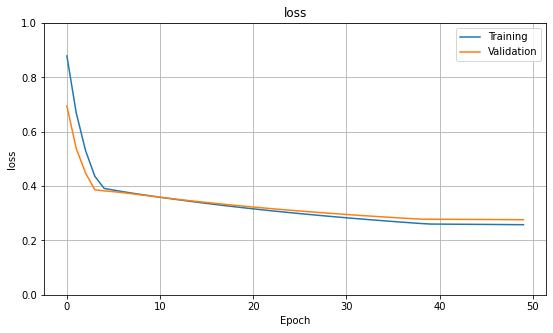



Training overall_accuracy Min: 0.546, Max: 0.918 in epoch 49, Current: 0.918
Validation overall_accuracy Min: 0.638, Max: 0.888 in epoch 37, Current: 0.888


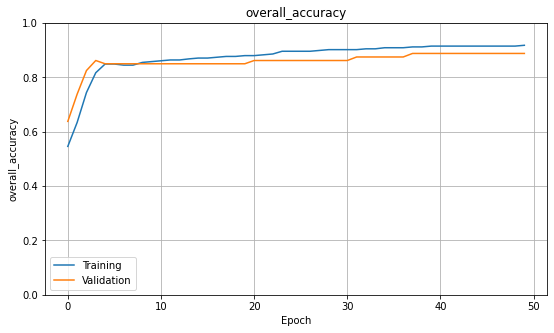



Training overall_cohen_kappa Min: 0.092, Max: 0.836 in epoch 49, Current: 0.836
Validation overall_cohen_kappa Min: 0.273, Max: 0.775 in epoch 37, Current: 0.775


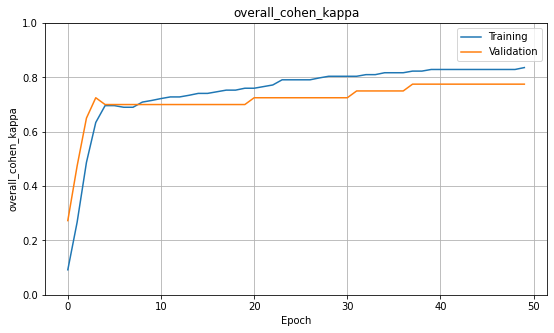



Training overall_recall Min: 0.546, Max: 0.918 in epoch 49, Current: 0.918
Validation overall_recall Min: 0.636, Max: 0.888 in epoch 37, Current: 0.888


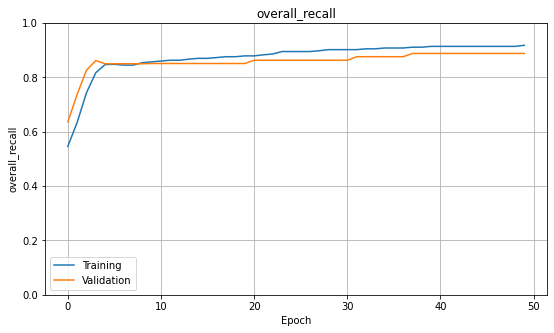



Training overall_f1_score Min: 0.546, Max: 0.918 in epoch 49, Current: 0.918
Validation overall_f1_score Min: 0.636, Max: 0.887 in epoch 37, Current: 0.887


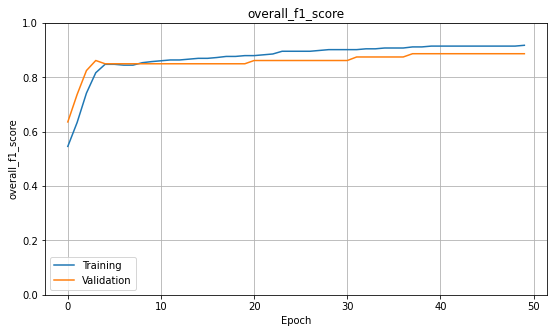



Training overall_precision Min: 0.546, Max: 0.918 in epoch 49, Current: 0.918
Validation overall_precision Min: 0.638, Max: 0.889 in epoch 37, Current: 0.889


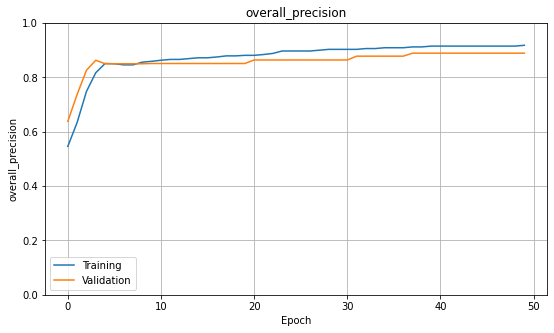



Training overall_specificity Min: 0.546, Max: 0.918 in epoch 49, Current: 0.918
Validation overall_specificity Min: 0.636, Max: 0.888 in epoch 37, Current: 0.888


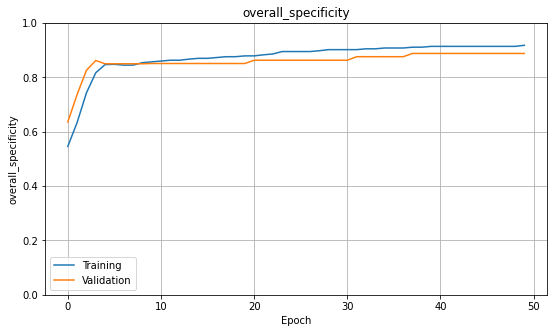

In [12]:
# Restore Best model
model_pkl = f'{model_name}.pkl'

# Best Evaluation metrics
ModelTraining.best_model_metrics_visualization(model_pkl)